In [3]:
#Round3-25
import os
import shutil
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import MobileNetV2, ResNet50, VGG16, EfficientNetB0
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess



In [4]:
# --- PATH CONFIGURATION ---
round3_base_path = r'C:\Users\gajje\OneDrive\Desktop\Major\Lung_diagnosis_files\Dataset\Dataset\Dataset\round-3'
percent_folder = '25'

base_percent_path = os.path.join(round3_base_path, percent_folder)
level1_path = os.path.join(base_percent_path, 'Level1', '10%Base')
level2_path = os.path.join(base_percent_path, 'Level2', 'Inbox')
level3_path = os.path.join(base_percent_path, 'Level3', 'Outbox')
training_paths = [os.path.join(base_percent_path, 'Training', sub) for sub in ['90%Base', 'Th1', 'Th2', 'Th3']]

r3_train_dir = f'round3_{percent_folder}/train'
r3_test1_dir = f'round3_{percent_folder}/test1'
r3_test2_dir = f'round3_{percent_folder}/test2'
r3_test3_dir = f'round3_{percent_folder}/test3'

for folder in [r3_train_dir, r3_test1_dir, r3_test2_dir, r3_test3_dir]:
    shutil.rmtree(folder, ignore_errors=True)
    os.makedirs(folder, exist_ok=True)

def split_and_copy(src_folder, dst_folder):
    for label in os.listdir(src_folder):
        src = os.path.join(src_folder, label)
        dst = os.path.join(dst_folder, label)
        os.makedirs(dst, exist_ok=True)
        for f in os.listdir(src):
            if f.lower().endswith(('jpg', 'jpeg', 'png')):
                shutil.copy(os.path.join(src, f), os.path.join(dst, f))

for p in training_paths: split_and_copy(p, r3_train_dir)
split_and_copy(level1_path, r3_test1_dir)
split_and_copy(level2_path, r3_test2_dir)
split_and_copy(level3_path, r3_test3_dir)

# --- IMAGE GENERATORS ---
img_size = (128, 128)
batch_size = 16
datagen = ImageDataGenerator(rescale=1./255)

train_data = datagen.flow_from_directory(r3_train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
test1_data = datagen.flow_from_directory(r3_test1_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)
test2_data = datagen.flow_from_directory(r3_test2_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)
test3_data = datagen.flow_from_directory(r3_test3_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)


Found 1404 images belonging to 3 classes.
Found 157 images belonging to 3 classes.
Found 534 images belonging to 3 classes.
Found 648 images belonging to 3 classes.


In [5]:
# --- HELPER FUNCTIONS ---
def evaluate_model(model, test_data, name):
    print(f"\n📌 Evaluation on {name}:")
    loss, acc = model.evaluate(test_data, verbose=0)
    print(f"Accuracy on {name}: {acc:.4f}")
    
    preds = model.predict(test_data)
    y_pred = np.argmax(preds, axis=1)
    y_true = test_data.classes
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=list(test_data.class_indices.keys())))
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_data.class_indices.keys(), yticklabels=test_data.class_indices.keys())
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


In [6]:
# --- MODEL DEFINITIONS ---
def get_custom_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')
    ])
    return model

def get_pretrained_model(base_model_class, name):
    base = base_model_class(weights='imagenet', include_top=False, input_shape=(128,128,3))
    base.trainable = False
    model = Sequential([
        base,
        GlobalAveragePooling2D(),
        Dropout(0.2),
        Dense(3, activation='softmax')
    ])
    return model

def get_alexnet():
    model = Sequential([
        Conv2D(96, (11,11), strides=(4,4), activation='relu', input_shape=(128,128,3)),
        MaxPooling2D(3, strides=2),
        Conv2D(256, (5,5), activation='relu', padding="same"),
        MaxPooling2D(3, strides=2),
        Conv2D(384, (3,3), activation='relu', padding="same"),
        Conv2D(384, (3,3), activation='relu', padding="same"),
        Conv2D(256, (3,3), activation='relu', padding="same"),
        MaxPooling2D(3, strides=2),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])
    return model




In [7]:
# --- TRAINING CONFIG ---
EPOCHS = 10
models = {
    "Custom CNN": get_custom_model(),
    "MobileNetV2": get_pretrained_model(MobileNetV2, 'MobileNetV2'),
    "ResNet50": get_pretrained_model(ResNet50, 'ResNet50'),
    "VGG16": get_pretrained_model(VGG16, 'VGG16'),
    "EfficientNetB0": get_pretrained_model(EfficientNetB0, 'EfficientNetB0'),
    "AlexNet": get_alexnet()
}

C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# # --- TRAIN & EVALUATE EACH MODEL ---
# for name, model in models.items():
#     print(f"\n\n Training Model: {name}")
#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#     model.fit(train_data, epochs=EPOCHS, validation_data=test1_data, verbose=1)
    
#     evaluate_model(model, test1_data, "Level 1 (10% Base)")
#     evaluate_model(model, test2_data, "Level 2 (Inbox)")
#     evaluate_model(model, test3_data, "Level 3 (Outbox)")

# # # Store accuracies
# accuracies = {}

# # Train and evaluate each model
# for name, model in models.items():
#     print(f"\n Training {name}...")
#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#     model.fit(train_data, epochs=EPOCHS, validation_data=test1_data, verbose=0)

#     print(f" Finished training {name}. Now evaluating on Level 1 test set...")
#     loss, acc = model.evaluate(test1_data, verbose=0)
#     accuracies[name] = acc

# # Print all accuracies
# print("\n Model Accuracies:")
# for name, acc in accuracies.items():
#     print(f" {name} Accuracy: {acc:.4f}")




 Training Model: Custom CNN


C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 26s 253ms/step - accuracy: 0.3884 - loss: 1.4636 - val_accuracy: 0.3376 - val_loss: 1.0994
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 224ms/step - accuracy: 0.4329 - loss: 1.0711 - val_accuracy: 0.5669 - val_loss: 0.9993
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 229ms/step - accuracy: 0.6704 - loss: 0.8164 - val_accuracy: 0.7771 - val_loss: 0.5050
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 225ms/step - accuracy: 0.8723 - loss: 0.3401 - val_accuracy: 0.9045 - val_loss: 0.2840
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 220ms/step - accuracy: 0.9100 - loss: 0.2535 - val_accuracy: 0.9299 - val_loss: 0.1772
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 230ms/step - accuracy: 0.9521 - loss: 0.1662 - val_accuracy: 0.9363 - val_loss: 0.1760
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 220ms/step - accuracy: 0.9986 - loss: 0.0220 - val_accuracy: 0.9427 - val_loss: 0.1495
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 223ms/step - accuracy: 1.0000 - loss: 0.0052 - val_accu

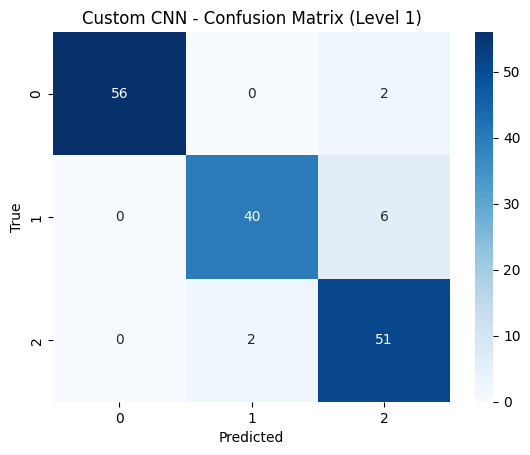


 Evaluating Custom CNN on Level 2 (Inbox)


C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       174
           1       0.87      0.87      0.87       180
           2       0.87      0.87      0.87       180

    accuracy                           0.91       534
   macro avg       0.91      0.91      0.91       534
weighted avg       0.91      0.91      0.91       534



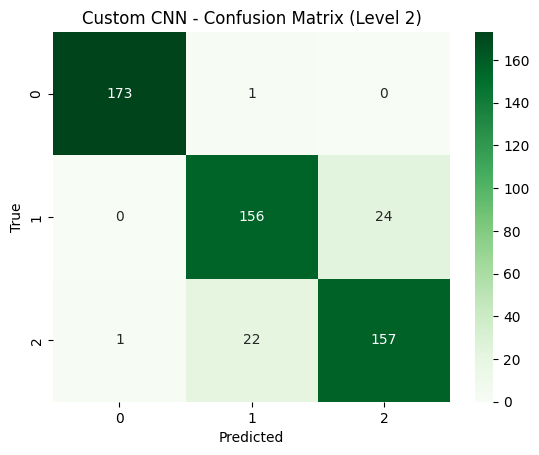


 Evaluating Custom CNN on Level 3 (Outbox)


C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step
              precision    recall  f1-score   support

           0       0.97      0.92      0.95       252
           1       0.78      0.75      0.77       144
           2       0.83      0.89      0.86       252

    accuracy                           0.87       648
   macro avg       0.86      0.85      0.86       648
weighted avg       0.87      0.87      0.87       648



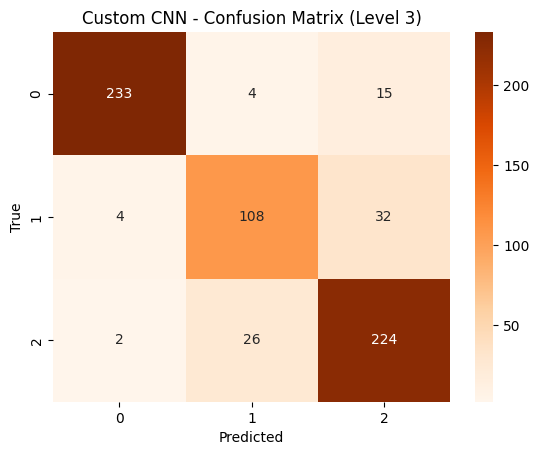



 Training Model: MobileNetV2
Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 32s 248ms/step - accuracy: 0.3439 - loss: 1.5614 - val_accuracy: 0.4013 - val_loss: 1.1108
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 19s 219ms/step - accuracy: 0.3936 - loss: 1.2206 - val_accuracy: 0.4586 - val_loss: 1.0704
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 29s 325ms/step - accuracy: 0.4477 - loss: 1.1336 - val_accuracy: 0.4904 - val_loss: 1.0406
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 25s 277ms/step - accuracy: 0.4167 - loss: 1.1309 - val_accuracy: 0.4586 - val_loss: 0.9983
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 25s 286ms/step - accuracy: 0.4629 - loss: 1.0874 - val_accuracy: 0.4904 - val_loss: 1.0120
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 19s 212ms/step - accuracy: 0.4938 - loss: 1.0340 - val_accuracy: 0.5414 - val_loss: 0.9683
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 19s 216ms/step - accuracy: 0.4983 - loss: 0.9886 - val_accuracy: 0.5032 - val_loss: 0.9800
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 154ms/step - accuracy: 0

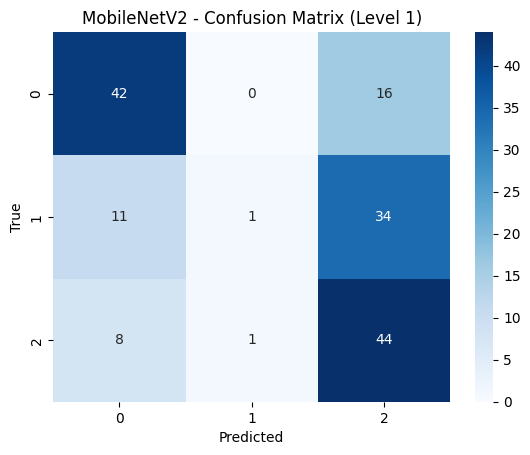


 Evaluating MobileNetV2 on Level 2 (Inbox)
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step
              precision    recall  f1-score   support

           0       0.57      0.48      0.52       174
           1       0.47      0.04      0.07       180
           2       0.40      0.83      0.54       180

    accuracy                           0.45       534
   macro avg       0.48      0.45      0.38       534
weighted avg       0.48      0.45      0.38       534



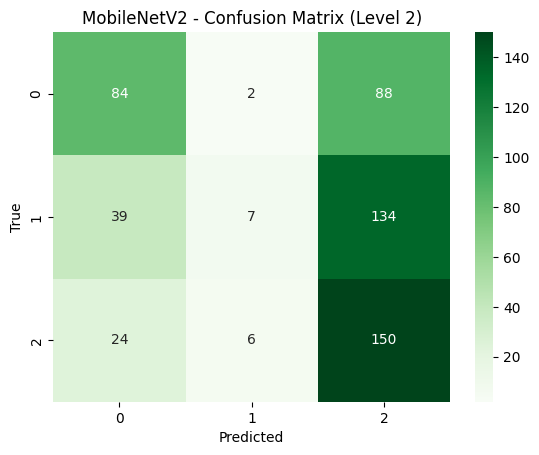


 Evaluating MobileNetV2 on Level 3 (Outbox)
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step
              precision    recall  f1-score   support

           0       0.65      0.62      0.63       252
           1       0.57      0.08      0.15       144
           2       0.51      0.79      0.62       252

    accuracy                           0.57       648
   macro avg       0.58      0.50      0.47       648
weighted avg       0.58      0.57      0.52       648



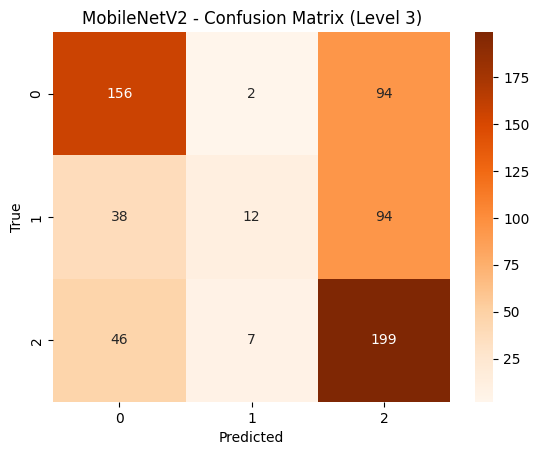



 Training Model: ResNet50
Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 58s 487ms/step - accuracy: 0.3575 - loss: 1.1182 - val_accuracy: 0.3822 - val_loss: 1.0933
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 30s 337ms/step - accuracy: 0.3728 - loss: 1.1008 - val_accuracy: 0.3694 - val_loss: 1.1022
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 29s 331ms/step - accuracy: 0.4097 - loss: 1.0954 - val_accuracy: 0.3376 - val_loss: 1.1142
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 35s 395ms/step - accuracy: 0.3903 - loss: 1.1055 - val_accuracy: 0.4013 - val_loss: 1.0874
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 24s 274ms/step - accuracy: 0.3735 - loss: 1.0871 - val_accuracy: 0.3694 - val_loss: 1.0881
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 26s 294ms/step - accuracy: 0.3816 - loss: 1.0930 - val_accuracy: 0.4076 - val_loss: 1.0885
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 26s 289ms/step - accuracy: 0.4339 - loss: 1.0782 - val_accuracy: 0.3376 - val_loss: 1.0972
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 26s 298ms/step - accuracy: 0.40

C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

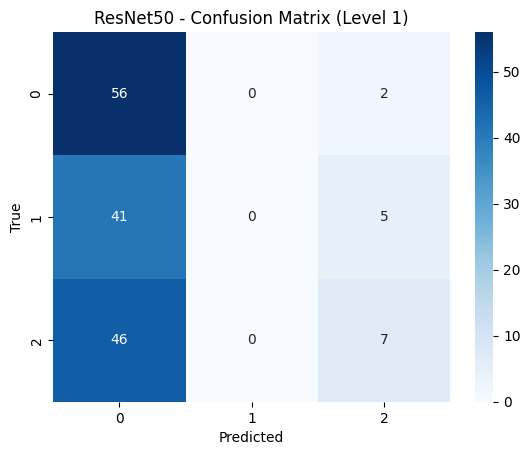


 Evaluating ResNet50 on Level 2 (Inbox)
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 277ms/step
              precision    recall  f1-score   support

           0       0.35      0.95      0.52       174
           1       0.00      0.00      0.00       180
           2       0.48      0.17      0.25       180

    accuracy                           0.37       534
   macro avg       0.28      0.38      0.26       534
weighted avg       0.28      0.37      0.25       534



C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

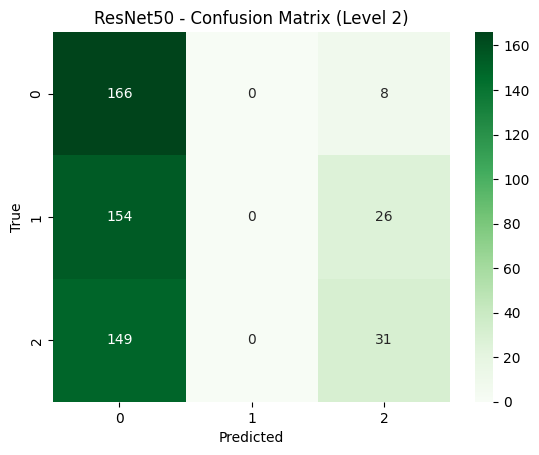


 Evaluating ResNet50 on Level 3 (Outbox)
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 277ms/step
              precision    recall  f1-score   support

           0       0.42      0.96      0.58       252
           1       0.00      0.00      0.00       144
           2       0.65      0.17      0.27       252

    accuracy                           0.44       648
   macro avg       0.36      0.38      0.28       648
weighted avg       0.42      0.44      0.33       648



C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

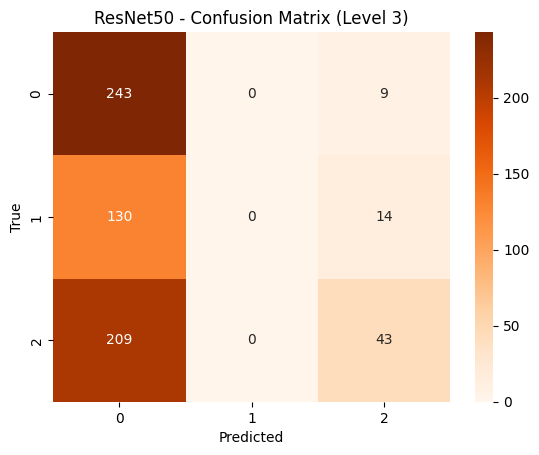



 Training Model: VGG16
Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 71s 792ms/step - accuracy: 0.3696 - loss: 1.1364 - val_accuracy: 0.3885 - val_loss: 1.0897
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 64s 728ms/step - accuracy: 0.3759 - loss: 1.0944 - val_accuracy: 0.4076 - val_loss: 1.0808
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 64s 722ms/step - accuracy: 0.3758 - loss: 1.1014 - val_accuracy: 0.3376 - val_loss: 1.0913
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 67s 758ms/step - accuracy: 0.3958 - loss: 1.0844 - val_accuracy: 0.4904 - val_loss: 1.0592
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 65s 739ms/step - accuracy: 0.4310 - loss: 1.0689 - val_accuracy: 0.4650 - val_loss: 1.0597
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.4445 - loss: 1.0550 - val_accuracy: 0.4586 - val_loss: 1.0519
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.4418 - loss: 1.0671 - val_accuracy: 0.3949 - val_loss: 1.0584
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 74s 833ms/step - accuracy: 0.4424 - los

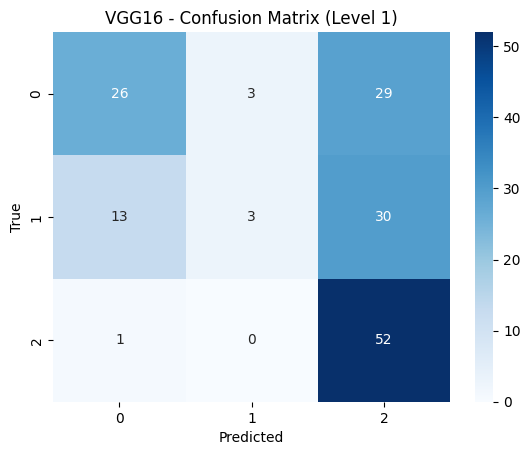


 Evaluating VGG16 on Level 2 (Inbox)
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 753ms/step
              precision    recall  f1-score   support

           0       0.60      0.43      0.50       174
           1       0.38      0.07      0.12       180
           2       0.38      0.79      0.51       180

    accuracy                           0.43       534
   macro avg       0.46      0.43      0.38       534
weighted avg       0.45      0.43      0.38       534



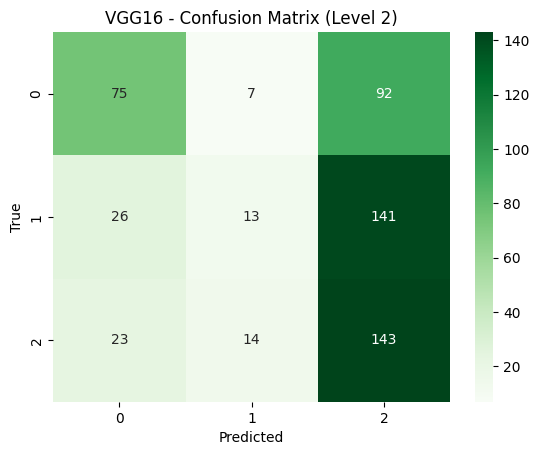


 Evaluating VGG16 on Level 3 (Outbox)
41/41 ━━━━━━━━━━━━━━━━━━━━ 30s 730ms/step
              precision    recall  f1-score   support

           0       0.66      0.42      0.52       252
           1       0.00      0.00      0.00       144
           2       0.46      0.88      0.60       252

    accuracy                           0.51       648
   macro avg       0.37      0.43      0.37       648
weighted avg       0.44      0.51      0.43       648



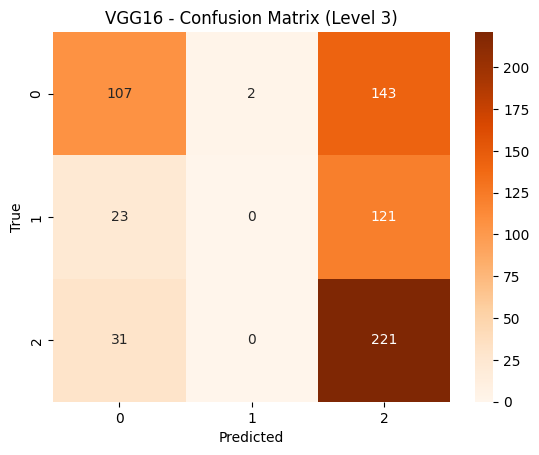



 Training Model: EfficientNetB0
Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 160ms/step - accuracy: 0.3354 - loss: 1.1201 - val_accuracy: 0.3376 - val_loss: 1.1037
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 0.3439 - loss: 1.1156 - val_accuracy: 0.3376 - val_loss: 1.1290
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - accuracy: 0.3633 - loss: 1.1092 - val_accuracy: 0.3376 - val_loss: 1.1497
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.3748 - loss: 1.1155 - val_accuracy: 0.3376 - val_loss: 1.1149
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - accuracy: 0.3522 - loss: 1.1243 - val_accuracy: 0.3694 - val_loss: 1.0944
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - accuracy: 0.3528 - loss: 1.1121 - val_accuracy: 0.3376 - val_loss: 1.1209
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - accuracy: 0.3624 - loss: 1.0986 - val_accuracy: 0.3376 - val_loss: 1.1320
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy

C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

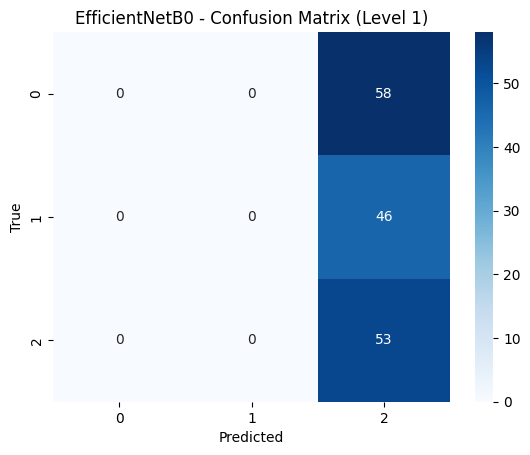


 Evaluating EfficientNetB0 on Level 2 (Inbox)
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       174
           1       0.00      0.00      0.00       180
           2       0.34      1.00      0.50       180

    accuracy                           0.34       534
   macro avg       0.11      0.33      0.17       534
weighted avg       0.11      0.34      0.17       534



C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

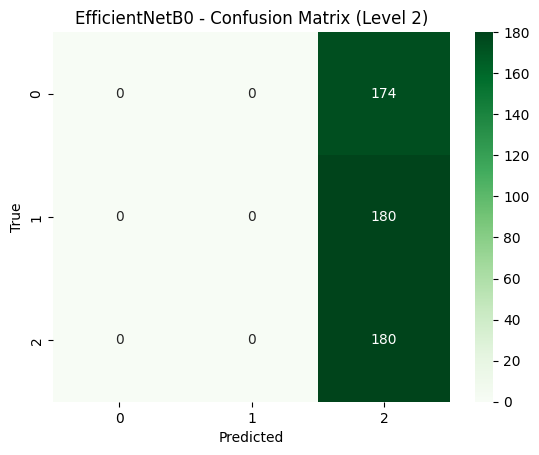


 Evaluating EfficientNetB0 on Level 3 (Outbox)
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       252
           1       0.00      0.00      0.00       144
           2       0.39      1.00      0.56       252

    accuracy                           0.39       648
   macro avg       0.13      0.33      0.19       648
weighted avg       0.15      0.39      0.22       648



C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

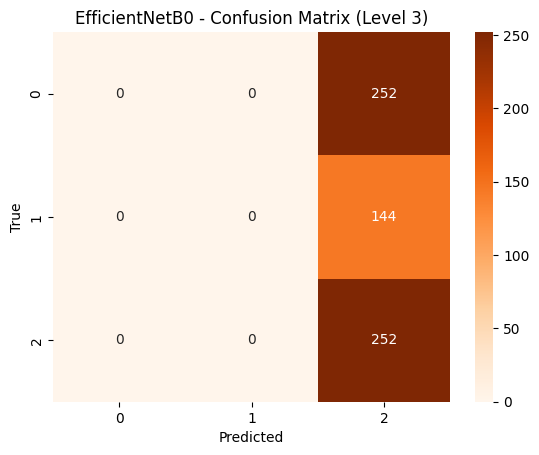



 Training Model: AlexNet
Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 26s 278ms/step - accuracy: 0.3707 - loss: 1.4561 - val_accuracy: 0.3376 - val_loss: 1.0967
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 23s 265ms/step - accuracy: 0.3711 - loss: 1.0931 - val_accuracy: 0.3376 - val_loss: 1.0954
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 23s 256ms/step - accuracy: 0.3594 - loss: 1.0947 - val_accuracy: 0.3376 - val_loss: 1.1012
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 23s 259ms/step - accuracy: 0.3930 - loss: 1.0891 - val_accuracy: 0.3376 - val_loss: 1.0973
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 24s 267ms/step - accuracy: 0.3856 - loss: 1.0928 - val_accuracy: 0.3376 - val_loss: 1.0960
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 23s 264ms/step - accuracy: 0.3852 - loss: 1.0947 - val_accuracy: 0.3376 - val_loss: 1.0999
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 23s 266ms/step - accuracy: 0.3803 - loss: 1.0940 - val_accuracy: 0.3376 - val_loss: 1.1006
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 23s 264ms/step - accuracy: 0.391

C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

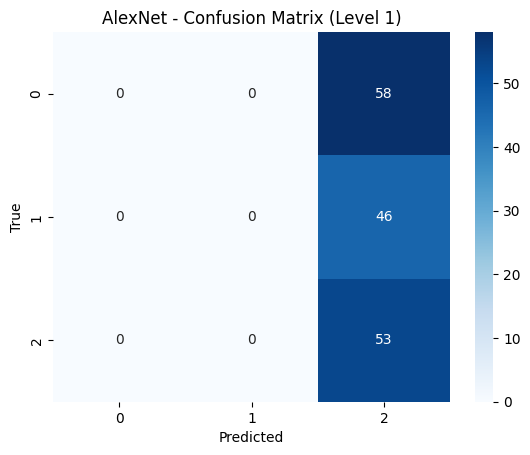


 Evaluating AlexNet on Level 2 (Inbox)
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       174
           1       0.00      0.00      0.00       180
           2       0.34      1.00      0.50       180

    accuracy                           0.34       534
   macro avg       0.11      0.33      0.17       534
weighted avg       0.11      0.34      0.17       534



C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

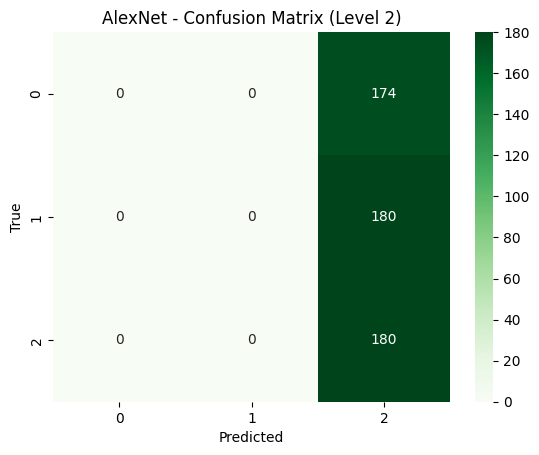


 Evaluating AlexNet on Level 3 (Outbox)
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       252
           1       0.00      0.00      0.00       144
           2       0.39      1.00      0.56       252

    accuracy                           0.39       648
   macro avg       0.13      0.33      0.19       648
weighted avg       0.15      0.39      0.22       648



C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

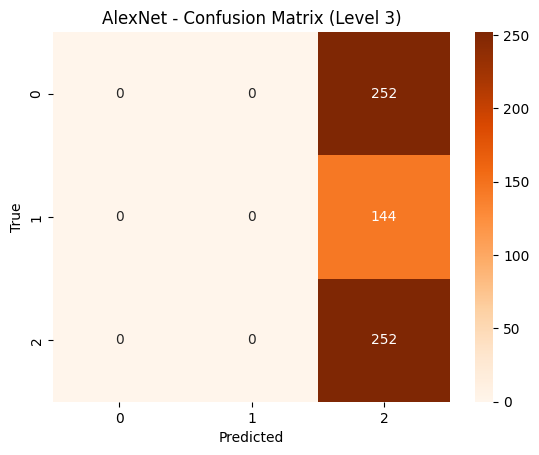

In [8]:
# Dictionary to store accuracies for Level 1
accuracies = {}

# --- TRAIN & EVALUATE EACH MODEL ---
for name, model in models.items():
    print(f"\n\n Training Model: {name}")
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(train_data, epochs=EPOCHS, validation_data=test1_data, verbose=1)

    # Evaluation on Level 1
    print(f"\n Evaluating {name} on Level 1 (10% Base)")
    loss1, acc1 = model.evaluate(test1_data, verbose=0)
    accuracies[name] = acc1  # Store Level 1 accuracy

    preds1 = model.predict(test1_data)
    y_pred1 = np.argmax(preds1, axis=1)
    y_true1 = test1_data.classes
    print(classification_report(y_true1, y_pred1))
    sns.heatmap(confusion_matrix(y_true1, y_pred1), annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - Confusion Matrix (Level 1)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Evaluation on Level 2
    print(f"\n Evaluating {name} on Level 2 (Inbox)")
    loss2, acc2 = model.evaluate(test2_data, verbose=0)
    preds2 = model.predict(test2_data)
    y_pred2 = np.argmax(preds2, axis=1)
    y_true2 = test2_data.classes
    print(classification_report(y_true2, y_pred2))
    sns.heatmap(confusion_matrix(y_true2, y_pred2), annot=True, fmt='d', cmap='Greens')
    plt.title(f'{name} - Confusion Matrix (Level 2)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Evaluation on Level 3
    print(f"\n Evaluating {name} on Level 3 (Outbox)")
    loss3, acc3 = model.evaluate(test3_data, verbose=0)
    preds3 = model.predict(test3_data)
    y_pred3 = np.argmax(preds3, axis=1)
    y_true3 = test3_data.classes
    print(classification_report(y_true3, y_pred3))
    sns.heatmap(confusion_matrix(y_true3, y_pred3), annot=True, fmt='d', cmap='Oranges')
    plt.title(f'{name} - Confusion Matrix (Level 3)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    plt.show()




In [9]:

# --- PRINT FINAL ACCURACY SUMMARY ---
print("\n Model Accuracies on Level 1 (10% Base):")
for name, acc in accuracies.items():
    print(f" {name} Accuracy: {acc:.4f}")


 Model Accuracies on Level 1 (10% Base):
 Custom CNN Accuracy: 0.9363
 MobileNetV2 Accuracy: 0.5541
 ResNet50 Accuracy: 0.4013
 VGG16 Accuracy: 0.5159
 EfficientNetB0 Accuracy: 0.3376
 AlexNet Accuracy: 0.3376


In [25]:
print(" Overall Model Accuracies:")
for model_name, acc in accuracies.items():
    print(f"{model_name}: {acc:.4f}")


 Overall Model Accuracies:
Custom CNN: 0.9363
MobileNetV2: 0.5541
ResNet50: 0.4013
VGG16: 0.5159
EfficientNetB0: 0.3376
AlexNet: 0.3376


In [8]:
# Dictionary to store accuracies for each model and level
round3_accuracies = {}


In [9]:
# Train each model and store the trained models
trained_models = {}

for name, model in models.items():
    print(f"\n\n Training Model: {name}")
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(train_data, epochs=EPOCHS, validation_data=test1_data, verbose=1)
    trained_models[name] = model  # Save the trained model




 Training Model: Custom CNN


C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 0.3672 - loss: 1.7539 - val_accuracy: 0.3376 - val_loss: 1.0961
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 25s 280ms/step - accuracy: 0.4059 - loss: 1.0898 - val_accuracy: 0.3376 - val_loss: 1.0973
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 31s 348ms/step - accuracy: 0.4023 - loss: 1.0851 - val_accuracy: 0.3376 - val_loss: 1.0896
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 18s 205ms/step - accuracy: 0.4221 - loss: 1.0381 - val_accuracy: 0.7643 - val_loss: 0.5436
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 160ms/step - accuracy: 0.7786 - loss: 0.5132 - val_accuracy: 0.8280 - val_loss: 0.5014
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 22s 245ms/step - accuracy: 0.9042 - loss: 0.2998 - val_accuracy: 0.8981 - val_loss: 0.2871
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 16s 183ms/step - accuracy: 0.9161 - loss: 0.2109 - val_accuracy: 0.8599 - val_loss: 0.2822
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 23s 261ms/step - accuracy: 0.9547 - loss: 0.1457 - val_accu


 Evaluating Custom CNN on Level 1 (10% Base)
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
              precision    recall  f1-score   support

           0       0.98      0.97      0.97        58
           1       1.00      0.78      0.88        46
           2       0.83      1.00      0.91        53

    accuracy                           0.92       157
   macro avg       0.94      0.92      0.92       157
weighted avg       0.94      0.92      0.92       157



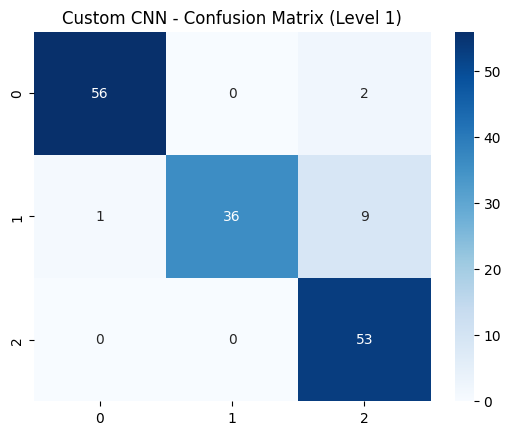


 Evaluating Custom CNN on Level 2 (Inbox)


C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       174
           1       0.85      0.47      0.60       180
           2       0.64      0.93      0.76       180

    accuracy                           0.79       534
   macro avg       0.82      0.79      0.78       534
weighted avg       0.82      0.79      0.78       534



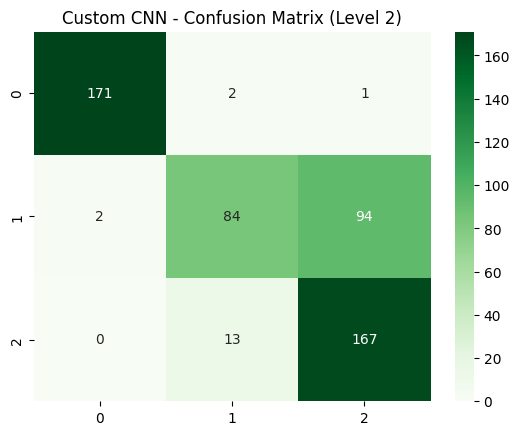


 Evaluating Custom CNN on Level 3 (Outbox)


C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       252
           1       0.83      0.47      0.60       144
           2       0.71      0.92      0.80       252

    accuracy                           0.81       648
   macro avg       0.83      0.76      0.77       648
weighted avg       0.82      0.81      0.80       648



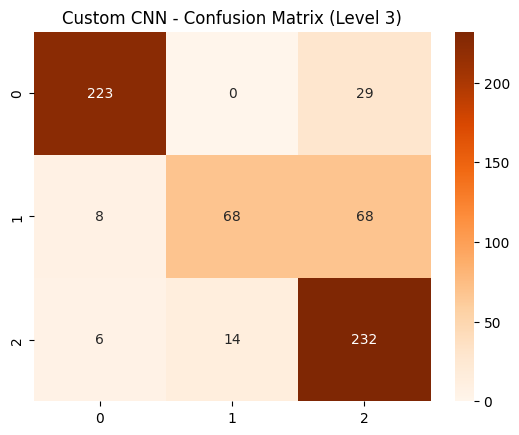


 Evaluating MobileNetV2 on Level 1 (10% Base)
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step
              precision    recall  f1-score   support

           0       0.69      0.81      0.75        58
           1       0.56      0.43      0.49        46
           2       0.58      0.58      0.58        53

    accuracy                           0.62       157
   macro avg       0.61      0.61      0.61       157
weighted avg       0.62      0.62      0.62       157



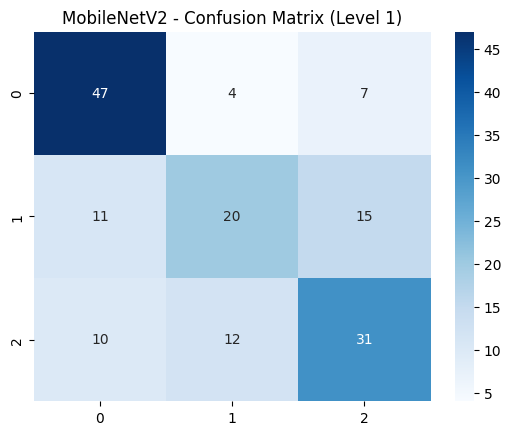


 Evaluating MobileNetV2 on Level 2 (Inbox)
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step
              precision    recall  f1-score   support

           0       0.56      0.55      0.56       174
           1       0.36      0.33      0.35       180
           2       0.41      0.45      0.43       180

    accuracy                           0.44       534
   macro avg       0.45      0.45      0.44       534
weighted avg       0.44      0.44      0.44       534



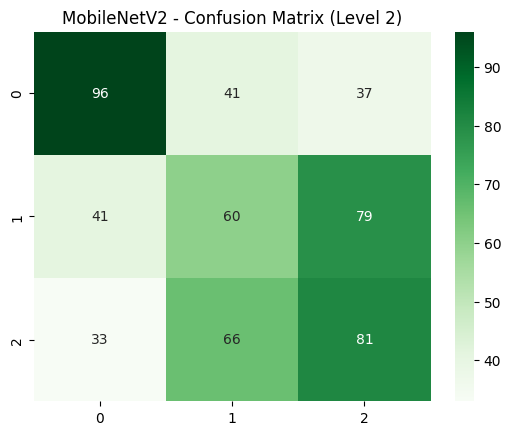


 Evaluating MobileNetV2 on Level 3 (Outbox)
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step
              precision    recall  f1-score   support

           0       0.63      0.73      0.67       252
           1       0.40      0.28      0.33       144
           2       0.61      0.61      0.61       252

    accuracy                           0.58       648
   macro avg       0.54      0.54      0.54       648
weighted avg       0.57      0.58      0.57       648



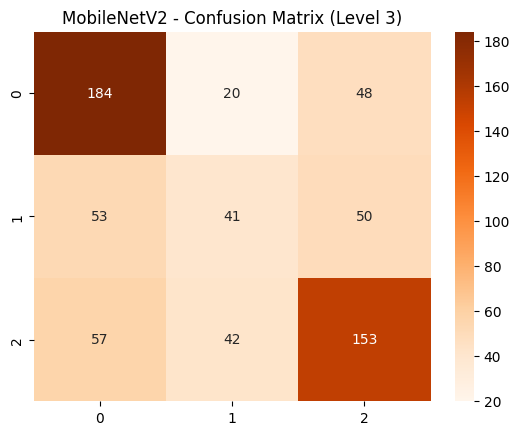


 Evaluating ResNet50 on Level 1 (10% Base)
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 422ms/step
              precision    recall  f1-score   support

           0       0.60      0.10      0.18        58
           1       0.33      0.07      0.11        46
           2       0.36      0.92      0.51        53

    accuracy                           0.37       157
   macro avg       0.43      0.36      0.27       157
weighted avg       0.44      0.37      0.27       157



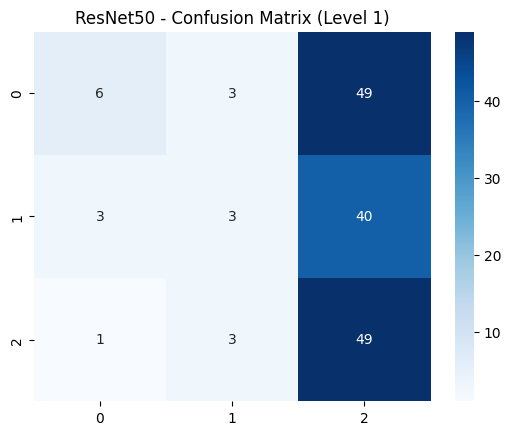


 Evaluating ResNet50 on Level 2 (Inbox)
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 260ms/step
              precision    recall  f1-score   support

           0       0.62      0.11      0.19       174
           1       0.50      0.06      0.10       180
           2       0.35      0.94      0.51       180

    accuracy                           0.37       534
   macro avg       0.49      0.37      0.27       534
weighted avg       0.49      0.37      0.27       534



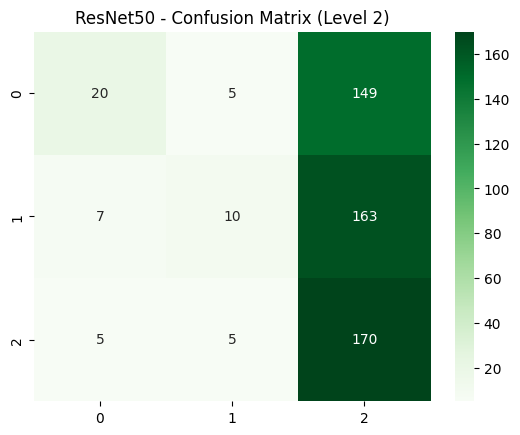


 Evaluating ResNet50 on Level 3 (Outbox)
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 249ms/step
              precision    recall  f1-score   support

           0       0.76      0.15      0.25       252
           1       0.50      0.01      0.03       144
           2       0.42      0.98      0.58       252

    accuracy                           0.44       648
   macro avg       0.56      0.38      0.29       648
weighted avg       0.57      0.44      0.33       648



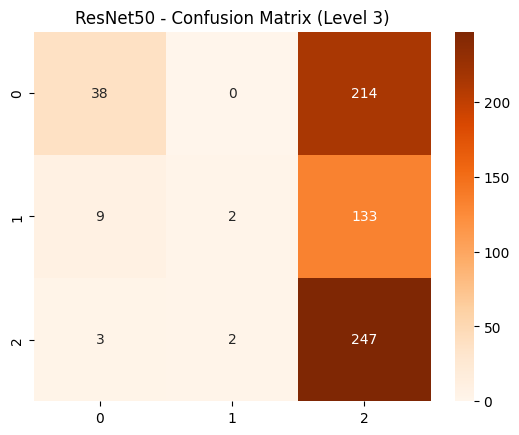


 Evaluating VGG16 on Level 1 (10% Base)
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 657ms/step
              precision    recall  f1-score   support

           0       0.71      0.43      0.54        58
           1       0.50      0.07      0.12        46
           2       0.45      0.98      0.62        53

    accuracy                           0.51       157
   macro avg       0.55      0.49      0.42       157
weighted avg       0.56      0.51      0.44       157



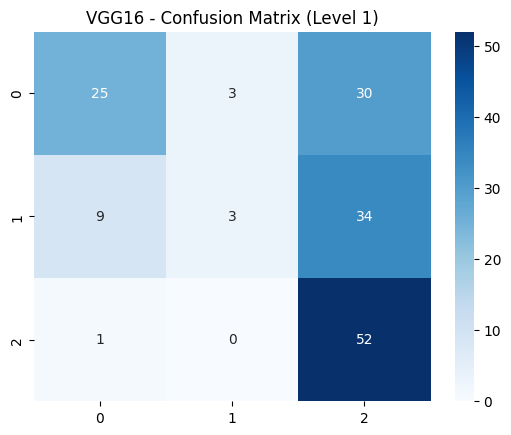


 Evaluating VGG16 on Level 2 (Inbox)
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 659ms/step
              precision    recall  f1-score   support

           0       0.70      0.36      0.47       174
           1       0.50      0.07      0.13       180
           2       0.37      0.86      0.52       180

    accuracy                           0.43       534
   macro avg       0.52      0.43      0.37       534
weighted avg       0.52      0.43      0.37       534



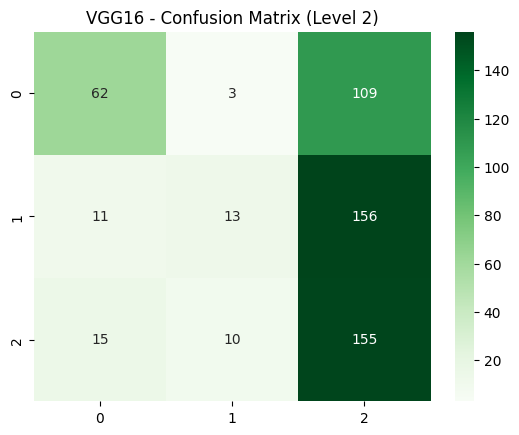


 Evaluating VGG16 on Level 3 (Outbox)
41/41 ━━━━━━━━━━━━━━━━━━━━ 25s 596ms/step
              precision    recall  f1-score   support

           0       0.73      0.35      0.47       252
           1       0.00      0.00      0.00       144
           2       0.45      0.94      0.61       252

    accuracy                           0.50       648
   macro avg       0.39      0.43      0.36       648
weighted avg       0.46      0.50      0.42       648



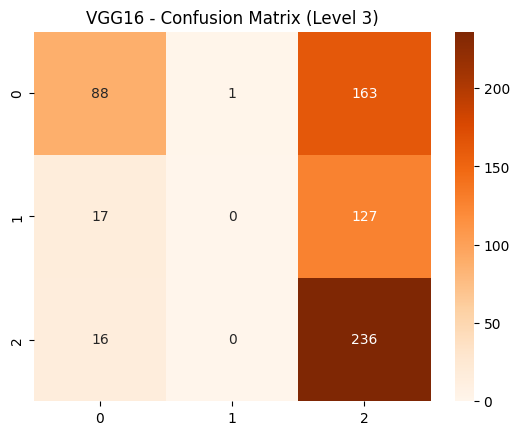


 Evaluating EfficientNetB0 on Level 1 (10% Base)
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 341ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        58
           1       0.00      0.00      0.00        46
           2       0.34      1.00      0.50        53

    accuracy                           0.34       157
   macro avg       0.11      0.33      0.17       157
weighted avg       0.11      0.34      0.17       157



C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

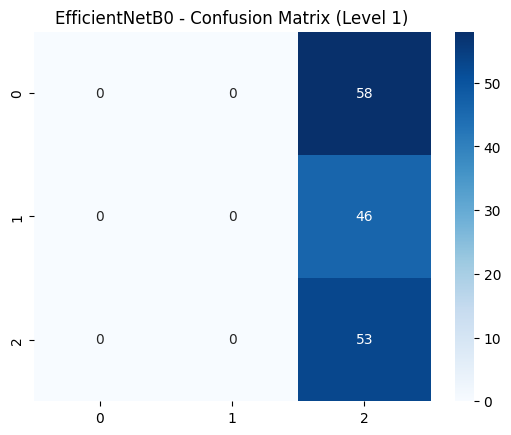


 Evaluating EfficientNetB0 on Level 2 (Inbox)
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       174
           1       0.00      0.00      0.00       180
           2       0.34      1.00      0.50       180

    accuracy                           0.34       534
   macro avg       0.11      0.33      0.17       534
weighted avg       0.11      0.34      0.17       534



C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

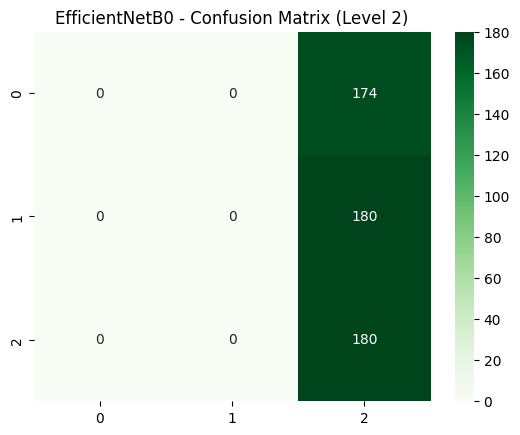


 Evaluating EfficientNetB0 on Level 3 (Outbox)
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       252
           1       0.00      0.00      0.00       144
           2       0.39      1.00      0.56       252

    accuracy                           0.39       648
   macro avg       0.13      0.33      0.19       648
weighted avg       0.15      0.39      0.22       648



C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

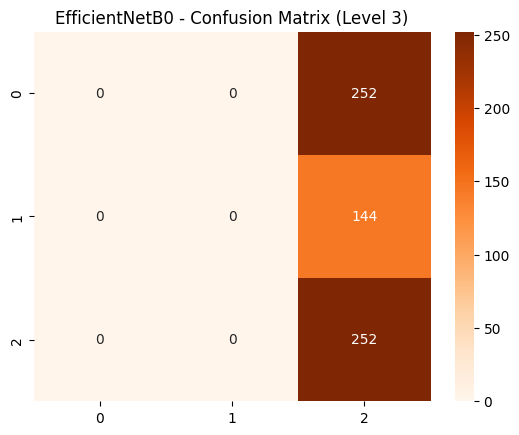


 Evaluating AlexNet on Level 1 (10% Base)
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        58
           1       0.00      0.00      0.00        46
           2       0.34      1.00      0.50        53

    accuracy                           0.34       157
   macro avg       0.11      0.33      0.17       157
weighted avg       0.11      0.34      0.17       157



C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

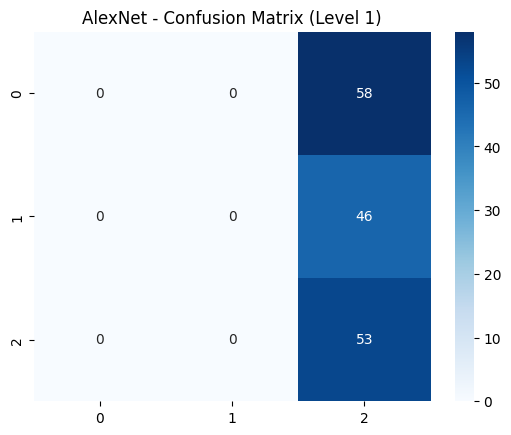


 Evaluating AlexNet on Level 2 (Inbox)
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       174
           1       0.00      0.00      0.00       180
           2       0.34      1.00      0.50       180

    accuracy                           0.34       534
   macro avg       0.11      0.33      0.17       534
weighted avg       0.11      0.34      0.17       534



C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

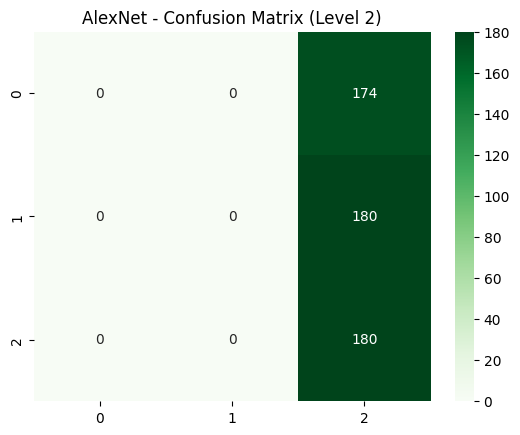


 Evaluating AlexNet on Level 3 (Outbox)
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       252
           1       0.00      0.00      0.00       144
           2       0.39      1.00      0.56       252

    accuracy                           0.39       648
   macro avg       0.13      0.33      0.19       648
weighted avg       0.15      0.39      0.22       648



C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

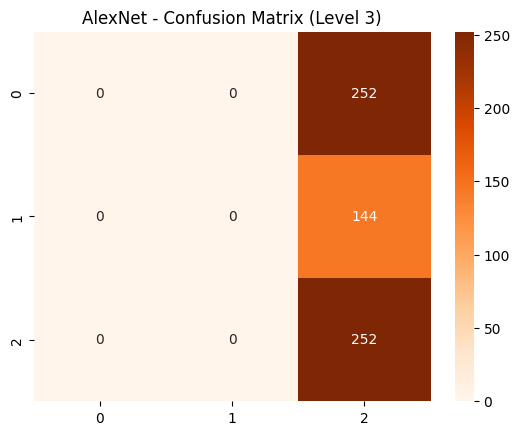

In [10]:
for name, model in trained_models.items():
    model_accs = {}

    # LEVEL 1
    print(f"\n Evaluating {name} on Level 1 (10% Base)")
    loss1, acc1 = model.evaluate(test1_data, verbose=0)
    model_accs['Level 1'] = acc1

    preds1 = model.predict(test1_data)
    y_pred1 = np.argmax(preds1, axis=1)
    y_true1 = test1_data.classes
    print(classification_report(y_true1, y_pred1))
    sns.heatmap(confusion_matrix(y_true1, y_pred1), annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - Confusion Matrix (Level 1)')
    plt.show()

    # LEVEL 2
    print(f"\n Evaluating {name} on Level 2 (Inbox)")
    loss2, acc2 = model.evaluate(test2_data, verbose=0)
    model_accs['Level 2'] = acc2

    preds2 = model.predict(test2_data)
    y_pred2 = np.argmax(preds2, axis=1)
    y_true2 = test2_data.classes
    print(classification_report(y_true2, y_pred2))
    sns.heatmap(confusion_matrix(y_true2, y_pred2), annot=True, fmt='d', cmap='Greens')
    plt.title(f'{name} - Confusion Matrix (Level 2)')
    plt.show()

    # LEVEL 3
    print(f"\n Evaluating {name} on Level 3 (Outbox)")
    loss3, acc3 = model.evaluate(test3_data, verbose=0)
    model_accs['Level 3'] = acc3

    preds3 = model.predict(test3_data)
    y_pred3 = np.argmax(preds3, axis=1)
    y_true3 = test3_data.classes
    print(classification_report(y_true3, y_pred3))
    sns.heatmap(confusion_matrix(y_true3, y_pred3), annot=True, fmt='d', cmap='Oranges')
    plt.title(f'{name} - Confusion Matrix (Level 3)')
    plt.show()

    # Save accuracy data
    round3_accuracies[name] = model_accs


In [11]:
print("\n Model Accuracies on Each Level and Overall Round 3:")

for name, accs in round3_accuracies.items():
    level1 = accs.get('Level 1', 0)
    level2 = accs.get('Level 2', 0)
    level3 = accs.get('Level 3', 0)
    overall = (level1 + level2 + level3) / 3

    print(f"\n{name}:")
    print(f" Level 1 Accuracy: {level1:.4f}")
    print(f" Level 2 Accuracy: {level2:.4f}")
    print(f" Level 3 Accuracy: {level3:.4f}")
    print(f" Round 3 Overall Accuracy: {overall:.4f}")



 Model Accuracies on Each Level and Overall Round 3:

Custom CNN:
 Level 1 Accuracy: 0.9236
 Level 2 Accuracy: 0.7903
 Level 3 Accuracy: 0.8071
 Round 3 Overall Accuracy: 0.8403

MobileNetV2:
 Level 1 Accuracy: 0.6242
 Level 2 Accuracy: 0.4438
 Level 3 Accuracy: 0.5833
 Round 3 Overall Accuracy: 0.5505

ResNet50:
 Level 1 Accuracy: 0.3694
 Level 2 Accuracy: 0.3745
 Level 3 Accuracy: 0.4429
 Round 3 Overall Accuracy: 0.3956

VGG16:
 Level 1 Accuracy: 0.5096
 Level 2 Accuracy: 0.4307
 Level 3 Accuracy: 0.5000
 Round 3 Overall Accuracy: 0.4801

EfficientNetB0:
 Level 1 Accuracy: 0.3376
 Level 2 Accuracy: 0.3371
 Level 3 Accuracy: 0.3889
 Round 3 Overall Accuracy: 0.3545

AlexNet:
 Level 1 Accuracy: 0.3376
 Level 2 Accuracy: 0.3371
 Level 3 Accuracy: 0.3889
 Round 3 Overall Accuracy: 0.3545
